# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Source catalogue

## Configuration

### Load libraries and setup

In [139]:
import numpy as np
from astropy.table import Table, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
from scipy.optimize import curve_fit
import pickle
import os
from pymoc import MOC

In [4]:
from mltier import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma, get_q_m, get_threshold, q0_min_level, q0_min_numbers)

In [5]:
%load_ext autoreload

In [6]:
%autoreload

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### General configuration

In [8]:
save_intermediate = True
plot_intermediate = True

In [9]:
idp = "idata/main"

In [10]:
if not os.path.isdir(idp):
    os.makedirs(idp)

### Area limits

In [11]:
ra_down0 = 170.0
ra_up0 = 190.0
dec_down0 = 45.5
dec_up0 = 56.5

In [12]:
# Busy week Edinburgh 2017
ra_down = 172.09
ra_up = 187.5833
dec_down = 46.106
dec_up = 56.1611

In [13]:
# Busy week Hatfield 2017
ra_down = 170.
ra_up = 190.
dec_down = 46.8
dec_up = 55.9

In [14]:
# Lockman Swire deep region south
ra_down = 150
ra_up = 170
dec_down = 50
dec_up = 70

#load the moc that describes the area where the maximum likelihood matching will occur
#MOC_loc = '/lustre/scratch/astro/im281/data/Lockman_swire_deep/dmu13-lockman-hole-1_MOC.fits'
MOC_loc = '../dmu2/dmu2_field_coverages/Lockman-SWIRE_MOC.fits'
MHz150_MOC = MOC(filename=MOC_loc)

In [15]:
MHz150_MOC.area* (180/np.pi)**2

22.413863402949218

In [16]:
field = Field(ra_down, ra_up, dec_down, dec_up, MHz150_MOC)
field_no_moc = Field(ra_down, ra_up, dec_down, dec_up)

field is using a MOC
290483669.7022219
field is not using MOC
2578860555.96


## Load data

In [17]:
lofar_150mhz = Table.read('data/deep-lockman-v0.1.cat.fits')
len(lofar_150mhz)

37165

In [18]:
np.array(lofar_150mhz.colnames)

array(['Source_id', 'Isl_id', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Total_flux',
       'E_Total_flux', 'Peak_flux', 'E_Peak_flux', 'RA_max', 'E_RA_max',
       'DEC_max', 'E_DEC_max', 'Maj', 'E_Maj', 'Min', 'E_Min', 'PA',
       'E_PA', 'Maj_img_plane', 'E_Maj_img_plane', 'Min_img_plane',
       'E_Min_img_plane', 'PA_img_plane', 'E_PA_img_plane', 'DC_Maj',
       'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'DC_PA', 'E_DC_PA',
       'DC_Maj_img_plane', 'E_DC_Maj_img_plane', 'DC_Min_img_plane',
       'E_DC_Min_img_plane', 'DC_PA_img_plane', 'E_DC_PA_img_plane',
       'Isl_Total_flux', 'E_Isl_Total_flux', 'Isl_rms', 'Isl_mean',
       'Resid_Isl_rms', 'Resid_Isl_mean', 'S_Code'], 
      dtype='<U18')

In [19]:
#irac_data = Table.read('/users/ianmccheyne/Documents/phd/data/master_catalogue_lockman-swire_iracall_20170710.fits')
irac_data = Table.read('../dmu1/dmu1_ml_Lockman-SWIRE/data/master_catalogue_lockman-swire_20170710.fits')
len(irac_data)

4641777

In [20]:
np.array(irac_data.colnames)

array(['help_id', 'field', 'ra', 'dec', 'hp_idx', 'f_ap_wfc_u',
       'ferr_ap_wfc_u', 'm_ap_wfc_u', 'merr_ap_wfc_u', 'f_wfc_u',
       'ferr_wfc_u', 'm_wfc_u', 'merr_wfc_u', 'flag_wfc_u', 'f_ap_wfc_g',
       'ferr_ap_wfc_g', 'm_ap_wfc_g', 'merr_ap_wfc_g', 'f_wfc_g',
       'ferr_wfc_g', 'm_wfc_g', 'merr_wfc_g', 'flag_wfc_g', 'f_ap_wfc_r',
       'ferr_ap_wfc_r', 'm_ap_wfc_r', 'merr_ap_wfc_r', 'f_wfc_r',
       'ferr_wfc_r', 'm_wfc_r', 'merr_wfc_r', 'flag_wfc_r', 'f_ap_wfc_i',
       'ferr_ap_wfc_i', 'm_ap_wfc_i', 'merr_ap_wfc_i', 'f_wfc_i',
       'ferr_wfc_i', 'm_wfc_i', 'merr_wfc_i', 'flag_wfc_i', 'f_ap_wfc_z',
       'ferr_ap_wfc_z', 'm_ap_wfc_z', 'merr_ap_wfc_z', 'f_wfc_z',
       'ferr_wfc_z', 'm_wfc_z', 'merr_wfc_z', 'flag_wfc_z', 'f_ap_rcs_g',
       'ferr_ap_rcs_g', 'm_ap_rcs_g', 'merr_ap_rcs_g', 'f_rcs_g',
       'ferr_rcs_g', 'm_rcs_g', 'merr_rcs_g', 'flag_rcs_g', 'f_ap_rcs_r',
       'ferr_ap_rcs_r', 'm_ap_rcs_r', 'merr_ap_rcs_r', 'f_rcs_r',
       'ferr_rcs_r', 'm_rcs_r'

In [21]:
len(irac_data['f_irac1'][irac_data['f_irac1'] == np.nan])
a = irac_data['f_irac1'][0]
len(irac_data['f_irac1'][irac_data['f_irac1'] == a])
b = irac_data['f_irac1'][1]
irac0 = []
iracnon0 = []
for n in range(len(irac_data['f_irac1'])):
    total = 0
    if np.isnan(irac_data['f_irac1'][n]) == True:
        if np.isnan(irac_data['f_irac2'][n]) == False:
            total = total + irac_data['f_irac2'][n]
        if np.isnan(irac_data['f_irac3'][n]) == False:
            total = total + irac_data['f_irac3'][n]
        if np.isnan(irac_data['f_irac4'][n]) == False:
            total = total + irac_data['f_irac4'][n]
        irac0.append(total)
    
    else:
        total = total + irac_data['f_irac1'][n]
        if np.isnan(irac_data['f_irac2'][n]) == False:
            total = total + irac_data['f_irac2'][n]
        if np.isnan(irac_data['f_irac3'][n]) == False:
            total = total + irac_data['f_irac3'][n]
        if np.isnan(irac_data['f_irac4'][n]) == False:
            total = total + irac_data['f_irac4'][n]
        iracnon0.append(total)
        

In [22]:
for n in range(len(irac0)):
    if irac0[n] <=0:
        irac0[n] = 0.01
for n in range(len(iracnon0)):
    if iracnon0[n] <=0:
        iracnon0[n] = 0.01

Text(0.5,0,'log(combined irac flux in all four bands)')

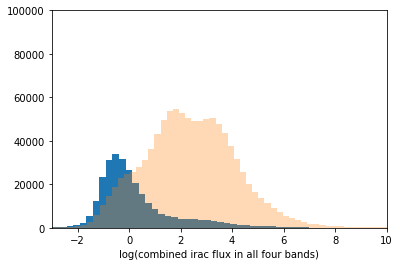

In [23]:
plt.hist(np.log(irac0),bins=100)
plt.hist(np.log(iracnon0),bins = 100,alpha= 0.3)
plt.xlim(-3,10)
plt.ylim(0,100000)
plt.xlabel('log(combined irac flux in all four bands)')

### Filter catalogues

In [24]:
lofar = field.filter_catalogue(lofar_150mhz, colnames=('RA','DEC'))
lofar = lofar[lofar['Maj']<30]
len(lofar)

filtering in a MOC
28194


28194

In [25]:
# currently filters in a rectangular area around the sources and does not 
#use a moc as the filter in a moc function wasn't working for some reason
combined = field.filter_catalogue(irac_data, colnames=('ra','dec'))
len(combined)

filtering in a MOC
4641747


4641747

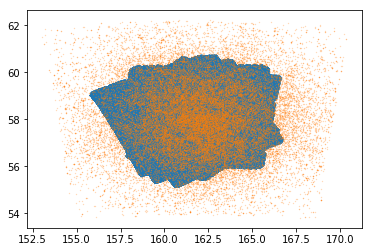

In [26]:
plt.scatter(irac_data['ra'],irac_data['dec'],s=0.1)
plt.scatter(lofar_150mhz['RA'],lofar_150mhz['DEC'],s=0.1,alpha= 0.4)
#plt.xlim(150,170)
#plt.ylim(50,70)

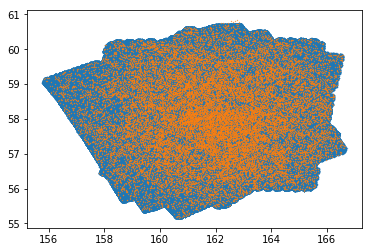

In [27]:
plt.scatter(combined['ra'],combined['dec'],s=0.1)
plt.scatter(lofar['RA'],lofar['DEC'],s=0.1)
#plt.xlim(159.5,165)
#plt.ylim(55,63)

### Additional data

### Sky coordinates

In [28]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [29]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Class of sources in the combined catalogue

The sources are grouped depending on the available photometric data.

## Description

### Sky coverage

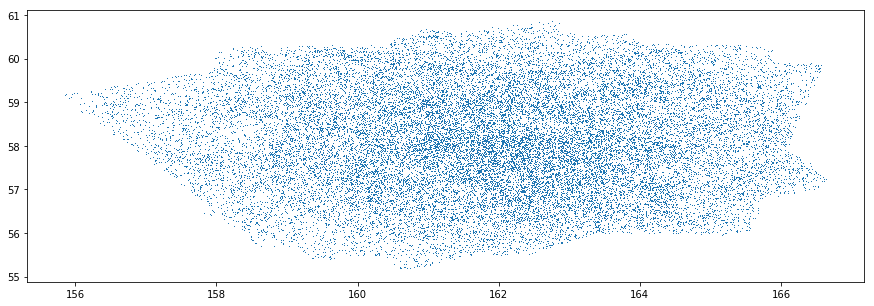

In [30]:
plt.rcParams["figure.figsize"] = (15,5)
plot(lofar["RA"],
     lofar["DEC"],
     ls="", marker=",");

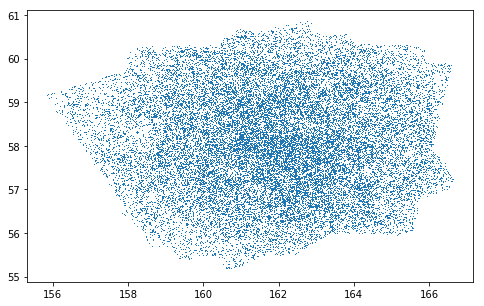

In [31]:
plt.rcParams["figure.figsize"] = (8,5)
plot(lofar["RA"],
     lofar["DEC"],
     ls="", marker=",");

In [32]:
len(lofar)

28194

In [33]:
combined["f_irac1"][np.isnan(combined["f_irac1"])] = 0

In [34]:
sum(combined['f_irac1'])

67404799.363389701

### Summary of galaxy types in the combined catalogue

Text(0.5,0,'i')

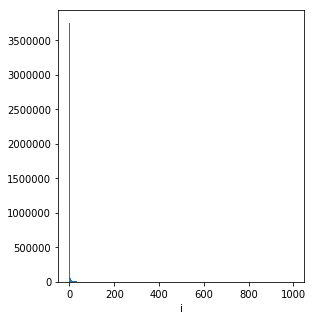

In [36]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["f_irac1"], bins=np.arange(0,1000,1))
xlabel("i")
#subplot(1,3,2)
#hist(combined["W1mag"][combined_matched], bins=50)
#xlabel("W1")
#subplot(1,3,3)
#hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50)
#xlabel("(i - W1)");

## Maximum Likelihood 1st

### i-band preparation

In [37]:
catalogue_i = combined

In [38]:
bin_list_i = np.linspace(0., 200., 401) # Bins of 0.5

In [39]:
center_i = get_center(bin_list_i)
# get the mid point of each bin i.e if there is a bin from 1 to 4 then the centre will be at 2.5

In [40]:
np.percentile(catalogue_i['f_irac1'],99)

90.829999999999998

In [41]:
#although the field was filtered in a rectangle around the sources the area is calcukated from the moc so is accurate
n_m_i = get_n_m(catalogue_i["f_irac1"], bin_list_i, field.area)
# get a cumulative distribution of the magnitudes divided by the field area

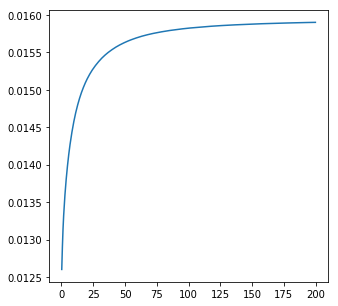

In [42]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, n_m_i);

In [43]:
q_m_i = estimate_q_m(catalogue_i["f_irac1"], bin_list_i, n_m_i, coords_lofar, coords_combined, radius=5)

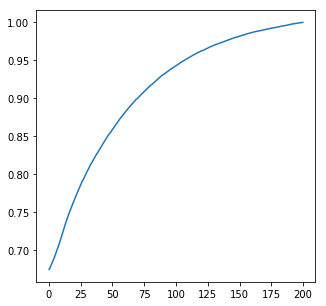

In [44]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, q_m_i);

### $Q_0$ and likelihood estimators

In [45]:
# Old
Q0_i = 0.545
Q0_w1 = 0.77
# Better Q0
Q0_i = 0.877
Q0_w1 = 0.699
q0 = Q0_i

In [46]:
likelihood_ratio_i = SingleMLEstimator(Q0_i, n_m_i, q_m_i, center_i)

### i-band match

In [47]:
radius = 10

In [48]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined, radius*u.arcsec)

In [49]:
idx_lofar_unique = np.unique(idx_lofar)
idx_i[idx_lofar == 3]

array([], dtype=int64)

In [50]:
idx_lofar_unique

array([    4,     7,     8, ..., 28191, 28192, 28193])

In [51]:
lofar["lr_i"] = np.nan                   # Likelihood ratio
lofar["lr_dist_i"] = np.nan              # Distance to the selected source
lofar["lr_index_i"] = np.nan             # Index of the PanSTARRS source in combined

In [52]:
total_sources = len(idx_lofar_unique)
combined_aux_index = np.arange(len(combined))

In [66]:
def ml(i):

#    print(i)
#    print(idx_lofar==i)
    
    idx_0 = idx_i[idx_lofar == i]
#    print(idx_0)
    d2d_0 = d2d[idx_lofar == i]
#    print(d2d_0)
#    i_mag = catalogue_i["flux_aper_1"][idx_0]
#    print(i_mag)
#    i_mag = catalogue_i["flux_aper_2"][idx_0]
#    print(i_mag)
#    i_mag = catalogue_i["flux_aper_3"][idx_0]
#    print(i_mag)
#    i_mag = catalogue_i["flux_aper_4"][idx_0]
#    print(i_mag)
#    i_mag = catalogue_i["flux_aper_5"][idx_0]
#    print(i_mag)
    i_mag = catalogue_i["f_irac1"][idx_0]
    
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_i["ra"][idx_0]
    c_dec = catalogue_i["dec"][idx_0]
#    c_ra_err = catalogue_i["raErr"][idx_0]
    c_ra_err = 1/3600
#    c_dec_err = catalogue_i["decErr"][idx_0]
    c_dec_err = 1/3600
    
    sigma = get_sigma(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_i(i_mag, d2d_0.arcsec, sigma)
#    print (lr_0)
    
    if len(lr_0) == 0:
        result = [nan,nan,nan,nan]
        return result
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],(i_mag[chosen_index])]                                  # LR

    return result

In [67]:
res = []
nomatches = 0
for i in range(len(lofar)):
    result = ml(i)
    if result == [nan,nan,nan,nan]:
        nomatches = nomatches + 1
    res.append(result)


In [68]:
print(nomatches)
print(len(res))
print(len(lofar["lr_index_i"][idx_lofar_unique]))

389
28194
27805


In [70]:
(lofar["lr_index_i"][idx_lofar_unique], 
 lofar["lr_dist_i"][idx_lofar_unique], 
 lofar["lr_i"][idx_lofar_unique],
 lofar['lr_i_flux']) = list(map(list, zip(*res)))

#### Threshold and selection for i-band

In [71]:
lofar["lr_i"][np.isnan(lofar["lr_i"])] = 0

In [72]:
#threshold is taken for sources whose likelihood is greater than 0
threshold_i = np.percentile(lofar[lofar['lr_i'] !=0]["lr_i"], 100*(1 - Q0_i))
#threshold_i = np.percentile(["lr_i"], 100*(1 - Q0_i))
Q0_i

0.877

In [73]:
threshold_i

0.015542476955910815

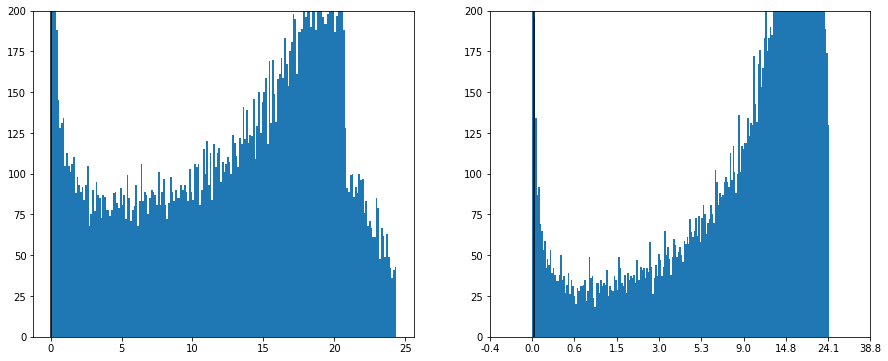

In [78]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_i"] != 0]["lr_i"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,200])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_i"] != 0]["lr_i"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,200]);

In [79]:
lofar["lrt"] = lofar["lr_i"]
lofar["lrt"][np.isnan(lofar["lr_i"])] = 0

In [80]:
def completeness(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr < threshold]
    return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/float(n)

def reliability(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr > threshold]
    return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/float(n)

completeness_v = np.vectorize(completeness, excluded=[0])
reliability_v = np.vectorize(reliability, excluded=[0])

In [81]:
n_test = 100
threshold_mean = np.percentile(lofar["lrt"], 100*(1 - q0))

In [82]:
thresholds = np.arange(0., 10., 0.01)
thresholds_fine = np.arange(0.1, 1., 0.001)

In [83]:
completeness_t = completeness_v(lofar["lrt"], thresholds, q0)
reliability_t = reliability_v(lofar["lrt"], thresholds, q0)
average_t = (completeness_t + reliability_t)/2

In [84]:
completeness_t_fine = completeness_v(lofar["lrt"], thresholds_fine, q0)
reliability_t_fine = reliability_v(lofar["lrt"], thresholds_fine, q0)
average_t_fine = (completeness_t_fine + reliability_t_fine)/2

In [85]:
threshold_sel = thresholds_fine[np.argmax(average_t_fine)]

Text(0,0.5,'Completeness/Reliability')

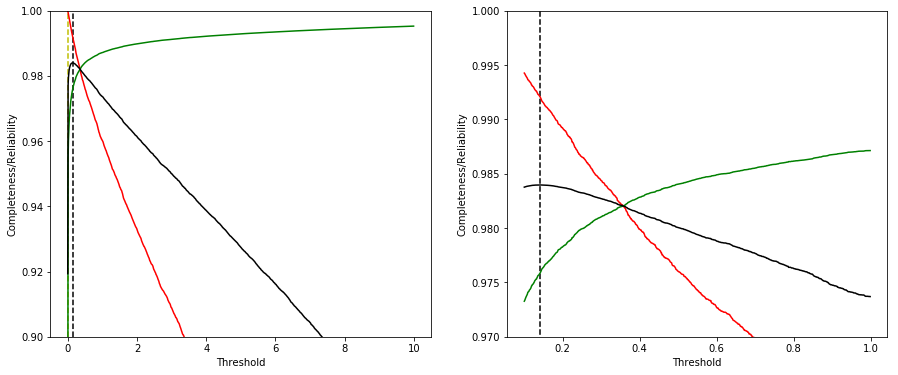

In [86]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
plot(thresholds, completeness_t, "r-")
plot(thresholds, reliability_t, "g-")
plot(thresholds, average_t, "k-")
vlines(threshold_sel, 0.9, 1., "k", linestyles="dashed")
vlines(threshold_mean, 0.9, 1., "y", linestyles="dashed")
ylim([0.9, 1.])
xlabel("Threshold")
ylabel("Completeness/Reliability")
subplot(1,2,2)
plot(thresholds_fine, completeness_t_fine, "r-")
plot(thresholds_fine, reliability_t_fine, "g-")
plot(thresholds_fine, average_t_fine, "k-")
vlines(threshold_sel, 0.9, 1., "k", linestyles="dashed")
#vlines(threshold_mean, 0.9, 1., "y", linestyles="dashed")
ylim([0.97, 1.])
xlabel("Threshold")
ylabel("Completeness/Reliability")

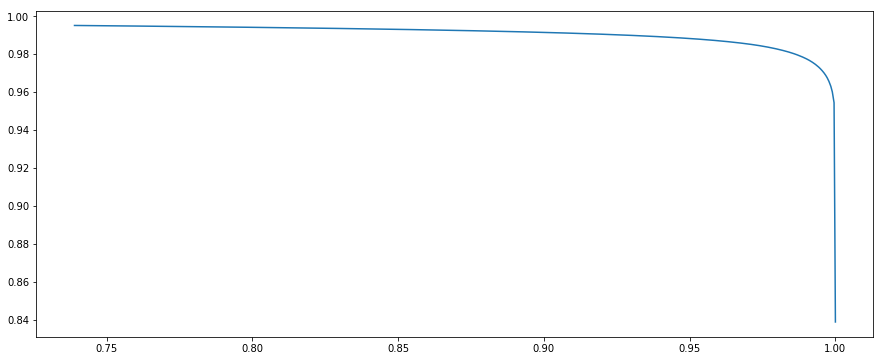

In [87]:
plt.rcParams["figure.figsize"] = (15,6)
plot(completeness_t,reliability_t)

In [88]:
print(threshold_sel)

0.14


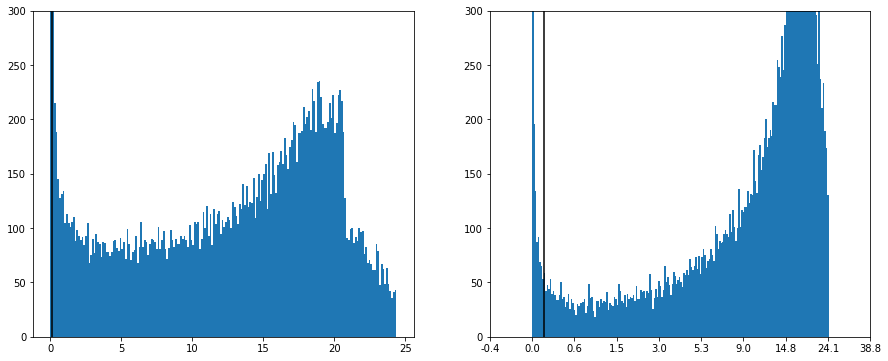

In [89]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lrt"] != 0]["lrt"], bins=200)
vlines([threshold_sel], 0, 500)
ylim([0,300])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lrt"] != 0]["lrt"]+1), bins=200)
vlines(np.log10(threshold_sel+1), 0, 500)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,300]);

##### create a table containing the lofar sources whose likelihood matches were above the new threshold and create a table of the data for the counterparts and then merge then using hstack

In [113]:
lofar_match = lofar[~np.isnan(lofar['lr_dist_i'])]
lofar_match = lofar_match[lofar_match['lr_i']>threshold_sel]
len(lofar_match)
lockman_match = Table(rows=combined[int(lofar_match['lr_index_i'][0])],names=combined.colnames)
for index in lofar_match['lr_index_i'][1:]:
    lockman_match.add_row(combined[int(index)])


1985973.0
1398190.0
1413105.0
2122306.0
1406190.0
1728151.0
1398221.0
1463053.0
1406114.0
1538182.0
2096184.0
1395064.0
1459197.0
1400394.0
1396751.0
1407802.0
2381492.0
1415170.0
1639511.0
2123380.0
1416714.0
2055209.0
1412207.0
2549215.0
1654842.0
1620279.0
1758623.0
2048295.0
2120711.0
2095696.0
1419930.0
1396513.0
1556846.0
1395884.0
2361263.0
1510617.0
1529430.0
1396441.0
1701907.0
1662697.0
2162248.0
2122720.0
1401068.0
1600788.0
1396719.0
1395943.0
1462105.0
2698208.0
2114997.0
2126127.0
1398530.0
1516522.0
1466732.0
1996252.0
1397915.0
1403267.0
1403808.0
1463681.0
2130414.0
1410230.0
1399128.0
1400728.0
1405932.0
1395596.0
3010834.0
1401719.0
2345210.0
3066698.0
4369595.0
1508493.0
1557128.0
2116273.0
1398252.0
1416624.0
1408142.0
1730731.0
3992768.0
1395740.0
4636633.0
1401223.0
1608321.0
1399352.0
1397470.0
1397200.0
1396812.0
1641717.0
1403952.0
1403443.0
1400322.0
1483107.0
4360892.0
1634933.0
1603145.0
4177312.0
2085314.0
1399338.0
1644319.0
1714661.0
1403614.0
4418836.0


4110768.0
1338408.0
327821.0
1325802.0
4203285.0
1369829.0
443614.0
360712.0
1378343.0
496484.0
4028445.0
255768.0
1332921.0
248734.0
4320276.0
4597435.0
1314511.0
1765543.0
1302318.0
1317468.0
1373786.0
4409301.0
1350866.0
4339455.0
4452734.0
1354754.0
3997759.0
4434000.0
433375.0
1349788.0
4096481.0
390685.0
4537364.0
4400171.0
4132910.0
1325185.0
4569843.0
460542.0
1363085.0
214315.0
4624789.0
4121511.0
1332860.0
1332980.0
351077.0
1337195.0
386849.0
1399310.0
1345646.0
1313436.0
1396580.0
202575.0
4026828.0
436032.0
463177.0
1344894.0
1362819.0
406192.0
1299143.0
1355771.0
424171.0
499474.0
1318458.0
1324603.0
4106437.0
424799.0
1368864.0
186025.0
1350687.0
1329923.0
1374130.0
1347646.0
412435.0
4126425.0
4600423.0
4571211.0
272008.0
327855.0
432689.0
435116.0
465630.0
4457246.0
4426894.0
403952.0
1311535.0
1371418.0
4119609.0
1335717.0
1354114.0
4619874.0
267613.0
1334199.0
1335441.0
1317302.0
4619143.0
4634531.0
430994.0
4630884.0
1343458.0
1401606.0
1364111.0
1325588.0
1308159.0

3991650.0
4246607.0
1328493.0
1385334.0
4232035.0
434802.0
1305502.0
448894.0
1349927.0
1364215.0
1319498.0
1362304.0
4637717.0
1383004.0
4535880.0
4134448.0
485173.0
3985121.0
490136.0
1301805.0
1330117.0
3982151.0
1327988.0
4029981.0
4180074.0
383090.0
4440358.0
1350270.0
282789.0
1307239.0
1351463.0
4624192.0
1406925.0
4498963.0
446497.0
4005829.0
1351184.0
4315151.0
346476.0
4187689.0
4113986.0
4381877.0
327614.0
507898.0
4167157.0
1354235.0
4039111.0
1324373.0
1313386.0
4427953.0
421760.0
465253.0
4101279.0
1351454.0
1386460.0
337525.0
1344589.0
3985149.0
1326308.0
209378.0
4020931.0
4634563.0
4003702.0
4436292.0
4222567.0
1327258.0
153135.0
4146946.0
1322451.0
1398179.0
4009029.0
4383711.0
1357101.0
4168893.0
1379184.0
4011726.0
4278143.0
4071345.0
4182114.0
249600.0
1318247.0
188346.0
4554052.0
4490346.0
4134294.0
1367934.0
1365022.0
4201072.0
1315864.0
1377245.0
1359626.0
4013517.0
1314725.0
472571.0
4192268.0
474413.0
1316841.0
4254792.0
202590.0
4306957.0
4601819.0
4615625.0


425739.0
1450489.0
4201200.0
4442831.0
4417633.0
484245.0
4194717.0
4250405.0
2102080.0
1348086.0
1377495.0
1488908.0
1324122.0
4595260.0
4190331.0
1579734.0
2645522.0
140.0
4402960.0
1342218.0
220169.0
4039994.0
2031910.0
4622329.0
4103634.0
4568842.0
1380729.0
1767845.0
4475190.0
4085752.0
4087042.0
1874302.0
4068358.0
4061551.0
4235900.0
4341818.0
4136776.0
2020780.0
1891017.0
4521590.0
1481416.0
1378507.0
1737182.0
1380248.0
1327078.0
4321883.0
2913007.0
470028.0
4406561.0
4472487.0
4302770.0
1243.0
1969567.0
4487837.0
496617.0
4521639.0
4197668.0
4194653.0
1338235.0
2034070.0
4543489.0
1585610.0
502108.0
4634833.0
1802755.0
4209796.0
4097450.0
4088882.0
4375004.0
1933865.0
1378169.0
4150967.0
4632006.0
4074069.0
4420702.0
1799486.0
4307450.0
4325108.0
4185295.0
4066380.0
4618836.0
4200344.0
4118210.0
1317131.0
1354970.0
4546400.0
1365936.0
4068300.0
4294998.0
4620721.0
4045070.0
3990620.0
4556542.0
1311251.0
474062.0
1367243.0
216227.0
4323764.0
4540019.0
4427329.0
4492345.0
46095

3241110.0
3156345.0
3318769.0
4055959.0
4001409.0
4124817.0
4002892.0
4020253.0
4063629.0
4022893.0
4483085.0
4231226.0
4061521.0
4047857.0
4400662.0
3127312.0
1332123.0
4397960.0
4086184.0
4064484.0
4399057.0
4110170.0
4111745.0
4100186.0
3168460.0
4493693.0
4037896.0
517460.0
4382364.0
4020320.0
4553037.0
4377320.0
3148984.0
3170723.0
4400997.0
4249083.0
4283869.0
1357742.0
4535072.0
4165157.0
4492689.0
3160857.0
3289695.0
4388850.0
4441829.0
3270335.0
1378568.0
1666824.0
3993006.0
3173557.0
4023144.0
3179472.0
281430.0
4268244.0
3299248.0
4122932.0
3297080.0
3145495.0
4097764.0
3986793.0
3986666.0
3299387.0
4066335.0
3767640.0
4219502.0
4055222.0
4071181.0
4029159.0
3180165.0
1651968.0
3301956.0
4156613.0
4207141.0
4338024.0
4334966.0
4468966.0
4342616.0
1850534.0
1674734.0
4336691.0
4087139.0
4128144.0
3150154.0
4176577.0
4018231.0
1329351.0
1337798.0
1702929.0
2184822.0
4262315.0
4201202.0
3199342.0
3293388.0
1764149.0
4405427.0
4253598.0
4061543.0
4246244.0
4368159.0
4405831.0
41

4424638.0
4134347.0
4308459.0
1765944.0
3176115.0
1368437.0
4120212.0
4033573.0
4212706.0
4287342.0
4149175.0
4353027.0
3203225.0
3836269.0
4281420.0
4088243.0
3563229.0
4344032.0
3236644.0
1395935.0
4135219.0
4145064.0
3313382.0
4135757.0
4129313.0
4446586.0
4210617.0
3164926.0
4067657.0
4213010.0
4123042.0
640731.0
4529796.0
4208171.0
4169850.0
4024283.0
4136972.0
4124212.0
3380484.0
4469932.0
106642.0
4471759.0
4321357.0
1336905.0
3667815.0
4339016.0
1384485.0
4123110.0
4556556.0
3296756.0
3289468.0
1319743.0
4137811.0
1336248.0
4322248.0
4272738.0
4221072.0
3137467.0
3123945.0
3289764.0
4122388.0
4462660.0
4267192.0
4205642.0
4281052.0
4173214.0
4253358.0
4397360.0
1300446.0
4229814.0
3174804.0
3159601.0
3188238.0
4620723.0
4277006.0
3163843.0
4479669.0
1344089.0
4120764.0
4483728.0
2776218.0
4487460.0
363191.0
3922972.0
4130824.0
4247709.0
4322364.0
1313184.0
1302866.0
4514225.0
4342664.0
3996894.0
3289352.0
3184699.0
4030056.0
1577233.0
4395177.0
4218684.0
4322337.0
4227698.0
402

4496576.0
4277380.0
4138027.0
4145473.0
676227.0
4338904.0
4490315.0
4042102.0
675388.0
3111842.0
4488258.0
4526682.0
4135282.0
4179979.0
4385969.0
4102860.0
3289457.0
4052462.0
4301941.0
4129615.0
4120263.0
4543453.0
1371083.0
4081573.0
4238740.0
4161881.0
4060952.0
4535844.0
3687421.0
4197628.0
4223229.0
1327567.0
3134392.0
4178301.0
4152880.0
4325448.0
3996954.0
4135892.0
4064571.0
3126893.0
4323637.0
4055629.0
4182321.0
4319106.0
4523527.0
4038358.0
258319.0
4213881.0
3234124.0
1309571.0
4527772.0
4464493.0
4232580.0
4276194.0
1316975.0
4117444.0
4201806.0
4512062.0
4240476.0
4036284.0
1313286.0
4105077.0
4266757.0
4387339.0
4154987.0
4284185.0
2060176.0
3592028.0
4535250.0
4566247.0
4295778.0
3855142.0
4100935.0
3126032.0
688408.0
4517502.0
4399689.0
4176788.0
4106329.0
4008831.0
3184751.0
1334000.0
3713045.0
1377632.0
3112304.0
4289891.0
4028085.0
3176788.0
1310167.0
3310148.0
4476860.0
4628981.0
4415058.0
213619.0
194767.0
4097976.0
4052863.0
3210267.0
4064834.0
4314536.0
416709

4323266.0
4430739.0
4270684.0
4106985.0
3287112.0
4407900.0
4213379.0
4176021.0
4209687.0
4240457.0
4229018.0
4541510.0
4026483.0
3992770.0
4055908.0
4141685.0
2263852.0
4194047.0
4351287.0
4337008.0
4172141.0
4324041.0
3676024.0
3996232.0
4457887.0
4209155.0
3704567.0
3328011.0
4628835.0
4093461.0
4092969.0
4002595.0
1346282.0
3120441.0
4195924.0
4127313.0
4123097.0
4054521.0
3189612.0
4548485.0
4030682.0
4215095.0
3989474.0
4061274.0
4024708.0
4131339.0
4137377.0
4015207.0
4007737.0
4105307.0
4225722.0
3297685.0
4181416.0
700127.0
4289280.0
3188968.0
1435179.0
4510602.0
4540320.0
4135267.0
4212015.0
4190537.0
3985012.0
4279853.0
3933423.0
3273541.0
4031087.0
3474128.0
4410743.0
4267797.0
1339198.0
4562297.0
4002396.0
4617578.0
4623978.0
1435039.0
4055529.0
3717570.0
4084314.0
1411017.0
4140432.0
4318791.0
256900.0
4003478.0
4280110.0
90273.0
3128326.0
4203141.0
4541438.0
4147062.0
1367976.0
4386330.0
3315238.0
3988576.0
3165076.0
4205491.0
704684.0
4309971.0
4535640.0
4110032.0
40197

3785282.0
4556855.0
1366524.0
4250796.0
4252625.0
4410195.0
4189398.0
4232848.0
4464863.0
4306825.0
120032.0
1378800.0
4412186.0
4027490.0
4211125.0
71011.0
3984961.0
4289663.0
4044710.0
3454438.0
2562002.0
4268519.0
4182538.0
4472041.0
85810.0
4267575.0
609704.0
4577276.0
211802.0
4121955.0
4503000.0
3224289.0
250895.0
4434165.0
4561633.0
4229500.0
4142683.0
223876.0
1386037.0
4161107.0
4284636.0
4108361.0
4457258.0
4018542.0
4004679.0
3322452.0
1360311.0
2638887.0
4327946.0
4009665.0
4248737.0
4116967.0
4062953.0
1303600.0
3344309.0
4083036.0
4364529.0
4158187.0
3149007.0
1349322.0
93092.0
1365240.0
4200499.0
686828.0
4421599.0
4336299.0
4342491.0
2421624.0
4068683.0
4396449.0
4191840.0
4462825.0
3177564.0
4179350.0
4011181.0
4529757.0
4165220.0
4362143.0
4121045.0
4153687.0
1344327.0
4169366.0
4031000.0
4141684.0
4008187.0
4050197.0
4484664.0
581259.0
4548730.0
4198290.0
4522568.0
3995930.0
3663822.0
3982711.0
4485664.0
4436471.0
4235704.0
1344109.0
4465269.0
4040596.0
4272443.0
409

4264389.0
4539638.0
3289202.0
16585.0
7176.0
4001734.0
4478731.0
4094283.0
4132742.0
110553.0
4487095.0
4183414.0
4328300.0
4511098.0
4417963.0
2080664.0
1945303.0
4567984.0
4161184.0
4470444.0
4223065.0
1503360.0
3993937.0
4547912.0
4391182.0
4266090.0
1404844.0
4570192.0
4470925.0
4060362.0
3112292.0
4078978.0
4487397.0
4397152.0
3619739.0
1583917.0
4265459.0
708197.0
1801459.0
4625141.0
4461930.0
4457559.0
3144928.0
2699274.0
2083329.0
4025104.0
4377059.0
4565490.0
3987341.0
1606277.0
1317573.0
4497821.0
4084696.0
4070451.0
1674520.0
4027644.0
4166293.0
4517160.0
4223838.0
4455879.0
4059659.0
4622121.0
4389608.0
4420418.0
4445793.0
3113506.0
1458826.0
4146793.0
4432576.0
4395149.0
4035646.0
4057030.0
4278206.0
3154207.0
4009904.0
4005093.0
4115981.0
4072204.0
4126926.0
4077439.0
1707800.0
4130981.0
1937172.0
4378787.0
4001956.0
4396044.0
4117088.0
4400286.0
4434813.0
3315010.0
4423272.0
4113232.0
4208537.0
1974258.0
4270763.0
4389838.0
4115384.0
4292038.0
4144576.0
4046982.0
2017700

1744714.0
4009413.0
3997949.0
4509528.0
4080591.0
3996139.0
4246050.0
4264652.0
4325500.0
4460989.0
4570309.0
4122840.0
4373717.0
4609868.0
4028451.0
4060751.0
4103523.0
4133491.0
4063361.0
4037281.0
2385804.0
4251531.0
4158741.0
1772891.0
4208695.0
4544287.0
4065178.0
4011327.0
4206107.0
1574953.0
4383899.0
4242690.0
4069152.0
4000656.0
4031857.0
4536794.0
4104260.0
4286356.0
4346418.0
4389650.0
4096836.0
4221106.0
4224194.0
4539067.0
4436821.0
4542194.0
4470749.0
3783035.0
2020112.0
558011.0
3472778.0
1845363.0
1692261.0
4117832.0
4521235.0
4030696.0
4133456.0
3160370.0
4463430.0
4066250.0
1328979.0
4008521.0
4337758.0
3988296.0
4428745.0
4356934.0
4001294.0
4614827.0
4006871.0
1314461.0
4133603.0
4553473.0
4320845.0
4045506.0
4553272.0
4153696.0
4340370.0
4120816.0
1437427.0
4185546.0
4373240.0
4050240.0
4187265.0
3995991.0
4536879.0
4536356.0
4020025.0
4532138.0
1787714.0
4557234.0
1451503.0
4057455.0
4021734.0
4553889.0
4397854.0
4304271.0
4222763.0
4479858.0
4551731.0
4107666.0
4

4165799.0
4282791.0
4157271.0
4204886.0
4443931.0
4024995.0
4004180.0
4154745.0
4169956.0
4073681.0
4118780.0
4278859.0
4311008.0
4390729.0
4478873.0
4031157.0
3991203.0
4220833.0
4157800.0
4122381.0
4169201.0
1975441.0
3184731.0
4247459.0
4048328.0
4485262.0
4382296.0
4072523.0
4185239.0
4163010.0
4361070.0
4014686.0
4340141.0
4487104.0
4143950.0
4027801.0
3757533.0
4446269.0
2725863.0
631008.0
4153120.0
4138018.0
581093.0
4123046.0
3419017.0
4030924.0
4152853.0
1965863.0
4491974.0
4086860.0
4221648.0
4134876.0
4029117.0
4164163.0
4088615.0
4215121.0
4346089.0
4446020.0
4306589.0
3760472.0
4311627.0
4488814.0
48326.0
4042107.0
4214423.0
1642050.0
4172015.0
4038413.0
588383.0
4568254.0
4187677.0
4545296.0
4327685.0
4048223.0
3989972.0
4096923.0
1628840.0
4319670.0
4124416.0
4076052.0
4293458.0
4084452.0
4017761.0
4033784.0
4081021.0
4057265.0
1669133.0
721261.0
4279438.0
4258880.0
4554203.0
4094006.0
4383786.0
4088529.0
3138256.0
4372980.0
4308966.0
4087923.0
4375303.0
4276512.0
188345

1682562.0
4036006.0
4476475.0
4088737.0
4539440.0
4426465.0
4570468.0
1462796.0
3883982.0
4038044.0
4455002.0
4396884.0
4560225.0
4285509.0
4170837.0
4529040.0
4105406.0
4142213.0
4301689.0
4456000.0
4463640.0
4240078.0
4489656.0
4500454.0
4096086.0
4157500.0
4616282.0
4170257.0
4002439.0
4131225.0
4355629.0
4352314.0
4287564.0
4112258.0
4531301.0
4391584.0
1302473.0
4262927.0
4025653.0
4430870.0
3986643.0
4321678.0
3646181.0
601328.0
4560060.0
4264234.0
4174161.0
4319452.0
4013707.0
4123388.0
4049140.0
4523386.0
4021088.0
4045357.0
4406530.0
4055596.0
4374986.0
4382199.0
4451465.0
4253305.0
4267218.0
4209812.0
4513659.0
3750092.0
4430083.0
4477845.0
4110580.0
4019057.0
4076615.0
4086123.0
4058306.0
4044367.0
4291161.0
4247831.0
4075693.0
4059276.0
4253780.0
3992219.0
3984427.0
4481831.0
4059246.0
3992930.0
4535498.0
4514262.0
4295939.0
1621574.0
1482952.0
4083021.0
4265834.0
4231477.0
4538740.0
4485026.0
4245701.0
712324.0
4470128.0
4497313.0
4387348.0
4009255.0
2183798.0
593689.0
415

4113813.0
4094719.0
4444552.0
4194544.0
4179028.0
4313431.0
4153448.0
4551170.0
4087282.0
4014552.0
4106237.0
4210365.0
4079447.0
4555706.0
4313138.0
4401972.0
4175753.0
4161536.0
4414060.0
1439962.0
4531284.0
4124334.0
4309801.0
4244704.0
4243390.0
3982413.0
4239137.0
4235203.0
4506410.0
4205665.0
4427760.0
4364057.0
119650.0
4154499.0
4058045.0
4485966.0
4180467.0
4141450.0
4207896.0
4436152.0
1887742.0
124311.0
4533547.0
4246339.0
4368055.0
1363908.0
4457966.0
4508347.0
4471433.0
3412506.0
4405723.0
4183493.0
4079079.0
4295848.0
4232044.0
80205.0
4530054.0
146835.0
4162131.0
4298614.0
4012822.0
4439911.0
4187167.0
4197478.0
3120286.0
4395733.0
201097.0
4259054.0
4473104.0
3996550.0
4505357.0
4518814.0
3226853.0
4221807.0
4256877.0
3615720.0
1306056.0
73108.0
1479447.0
4411929.0
4591337.0
3135666.0
4244241.0
3999517.0
4555309.0
4119747.0
4265696.0
1711183.0
4208494.0
4479725.0
4303074.0
906886.0
4399023.0
3686228.0
4310631.0
2179179.0
4513134.0
1313948.0
4030002.0
4059952.0
4245118.0

777219.0
4157379.0
4405587.0
4463060.0
4011570.0
4272206.0
4561717.0
4213122.0
4189186.0
4309516.0
3989861.0
4079902.0
4376304.0
4074485.0
4273202.0
4245398.0
4312572.0
4537250.0
4188912.0
4457046.0
4241679.0
4213486.0
4123391.0
4367193.0
4553811.0
4006489.0
3982229.0
4438142.0
904573.0
4347533.0
4326579.0
4471752.0
3840389.0
4165014.0
4073427.0
106181.0
3710856.0
4511878.0
4236486.0
905990.0
1708917.0
4066124.0
4317419.0
4493360.0
1348794.0
4305.0
4179236.0
4473882.0
4234579.0
4322202.0
4198633.0
4401625.0
4346853.0
4207594.0
4426597.0
4126472.0
4088017.0
4174978.0
4100594.0
4374788.0
1698500.0
4273839.0
4020692.0
4352122.0
4008232.0
4105255.0
4129604.0
4195906.0
4005241.0
4185105.0
4016063.0
4289858.0
2031127.0
4230591.0
4279584.0
4177552.0
4501461.0
4098548.0
3613493.0
4166269.0
4007073.0
4187669.0
4563952.0
1926050.0
4057610.0
4466374.0
4412995.0
4245998.0
4439255.0
4200111.0
4548053.0
4293571.0
4066056.0
4284118.0
4483650.0
4000605.0
4390096.0
4037497.0
4001045.0
4285037.0
4229213

4104702.0
3986596.0
3990576.0
4318881.0
3764077.0
4128586.0
4484826.0
4383570.0
4451404.0
4295654.0
4227076.0
4076177.0
4176079.0
3988905.0
4551917.0
820852.0
4196430.0
4107209.0
4160903.0
2275696.0
4271247.0
4307342.0
4284150.0
3992584.0
4602243.0
1325217.0
4564153.0
4179755.0
4031296.0
4116881.0
4536762.0
4082203.0
4238700.0
4052482.0
1498716.0
3985784.0
4330469.0
3731477.0
4204297.0
4516174.0
3287528.0
4136409.0
4610906.0
4252903.0
4089731.0
4349073.0
4293778.0
2242233.0
4410569.0
4445086.0
3183550.0
4341374.0
4414149.0
1386377.0
4071326.0
4572573.0
4439413.0
4229507.0
4172842.0
4541414.0
4533483.0
4555319.0
3280855.0
4013157.0
4308348.0
4155112.0
4269415.0
4208749.0
4066165.0
4015146.0
4417527.0
4215870.0
4249276.0
4478013.0
3766974.0
4256000.0
4186244.0
4201916.0
4596197.0
4121620.0
3228764.0
4155066.0
3989139.0
4463926.0
3989528.0
4509798.0
4411662.0
3799635.0
4201400.0
4059765.0
4066706.0
4086734.0
4064365.0
3677881.0
4276675.0
4542208.0
4099811.0
4313467.0
4074772.0
4257456.0
1

3982021.0
4155714.0
4513983.0
4055514.0
4193412.0
3982513.0
4142997.0
4270499.0
4461548.0
4339960.0
4236748.0
4069820.0
4198763.0
4145615.0
4364037.0
3623654.0
4545993.0
4546668.0
4343038.0
3751898.0
3994292.0
4404260.0
4361946.0
1361542.0
1978322.0
4131404.0
4408743.0
9236.0
4254671.0
4401190.0
4089443.0
4281978.0
3992816.0
4341040.0
4585709.0
3649270.0
4182888.0
4010667.0
4085080.0
4540274.0
4105925.0
4092143.0
1605867.0
4472742.0
4327285.0
4564124.0
1525026.0
4059135.0
4396147.0
4201051.0
3146303.0
4017849.0
4527305.0
4213110.0
3496942.0
4055091.0
3777717.0
4360338.0
3702685.0
4374939.0
4633248.0
4171080.0
4017084.0
4006914.0
4037973.0
4321787.0
4502138.0
4055807.0
4169017.0
3286068.0
1893554.0
4127326.0
4001448.0
4199877.0
3619191.0
4103147.0
3999804.0
4366233.0
4124099.0
4171346.0
4228360.0
4158026.0
4414895.0
4355564.0
4188513.0
4092279.0
4433657.0
4047948.0
4464184.0
1325045.0
4528867.0
4246493.0
2110089.0
892326.0
4387341.0
4244502.0
4426815.0
4536303.0
4184965.0
4076831.0
4030

4220135.0
1926857.0
4293660.0
4503243.0
4634535.0
1778098.0
4565411.0
3148432.0
4297058.0
3198723.0
4287990.0
4475592.0
4463619.0
4202491.0
3981424.0
4123370.0
4100478.0
4167706.0
4108690.0
4513410.0
1673920.0
71847.0
4005535.0
4084827.0
904556.0
4099660.0
4327781.0
4109865.0
4061288.0
4573352.0
3199018.0
4124376.0
4230792.0
4003884.0
3319180.0
1812254.0
4084894.0
2841335.0
4367959.0
1395923.0
4462343.0
4021076.0
4252577.0
2932861.0
4045278.0
4017219.0
1477917.0
3985914.0
4122080.0
4332168.0
4343897.0
4554301.0
4357032.0
4219778.0
4454945.0
1842506.0
3991456.0
4240154.0
4537264.0
4373929.0
3635138.0
4268321.0
3759811.0
4205172.0
4108891.0
4447175.0
4153473.0
4266510.0
3227727.0
4207931.0
904901.0
3123091.0
4158457.0
1334168.0
4067778.0
4310623.0
4458423.0
898069.0
4467056.0
4571790.0
4482680.0
4361080.0
4283489.0
4210076.0
4454641.0
4469154.0
4391715.0
3996242.0
4437856.0
4570735.0
1530990.0
4346834.0
4302201.0
4599147.0
4429453.0
4434938.0
4541903.0
4555233.0
4174753.0
4299660.0
41165

4540705.0
4341971.0
4184764.0
4411554.0
4311529.0
765071.0
4345803.0
4256787.0
4159979.0
4498888.0
4057720.0
4187109.0
3312090.0
4394201.0
4059927.0
3981670.0
4180801.0
4078739.0
4543905.0
4352763.0
735929.0
3173536.0
4198630.0
4179095.0
4391348.0
4283631.0
4133102.0
4518741.0
4372585.0
4114182.0
4374109.0
3988216.0
4083722.0
4106342.0
4075396.0
4317870.0
4295239.0
4414286.0
4104622.0
4265124.0
4076039.0
4310622.0
4408347.0
4375688.0
4293145.0
4488817.0
4157338.0
4527670.0
735088.0
3985018.0
4434069.0
4327872.0
4547287.0
4167801.0
4367089.0
4435078.0
4378592.0
4099813.0
3764255.0
4058714.0
4248236.0
3998862.0
4214077.0
4422214.0
4187672.0
4133280.0
4010287.0
4381846.0
3999732.0
4045655.0
4520993.0
4115956.0
1318749.0
4181123.0
4020623.0
4590524.0
905982.0
130442.0
3257656.0
4349351.0
4544218.0
4590544.0
4567860.0
2267769.0
4445823.0
4001590.0
4631443.0
4192468.0
4256077.0
4460462.0
4140478.0
3227004.0
4163928.0
4419313.0
2863374.0
4095758.0
4282748.0
4038841.0
4285434.0
4281307.0
41551

4099863.0
4364612.0
81677.0
897271.0
4140578.0
4430349.0
4252721.0
4260062.0
4263033.0
4468393.0
4117403.0
4473416.0
4393004.0
4391618.0
780327.0
4560184.0
4586596.0
4050341.0
4434245.0
4239563.0
2114648.0
4617430.0
4432168.0
4518738.0
791660.0
4057486.0
4045006.0
4553306.0
4521224.0
3631330.0
4030496.0
4564625.0
4171276.0
4534053.0
4266029.0
4375946.0
4500059.0
4120385.0
1380486.0
4556696.0
4038153.0
4060349.0
4030947.0
4092959.0
4056234.0
3174784.0
3996788.0
248757.0
4028707.0
3139735.0
4051428.0
4276268.0
4429222.0
4139033.0
4127368.0
4201708.0
4447918.0
4571890.0
4177991.0
4126443.0
1784727.0
4091587.0
4546466.0
2684219.0
4341196.0
4570398.0
4557887.0
4383227.0
4147127.0
4539679.0
4304217.0
4204504.0
4550191.0
4219950.0
4050602.0
239932.0
4147890.0
4061970.0
4483134.0
4326338.0
1342705.0
1304505.0
204695.0
4097354.0
4127693.0
732221.0
742934.0
4500485.0
3116267.0
4371795.0
4363246.0
4346430.0
4610344.0
4269810.0
4052987.0
3293589.0
896342.0
4603663.0
4270960.0
4420263.0
4029628.0
4

4276978.0
4390555.0
4598778.0
4495445.0
4394501.0
4438012.0
4426850.0
884109.0
4208378.0
3168786.0
1742147.0
780796.0
786180.0
3114919.0
4224677.0
2572899.0
4556485.0
4541050.0
4518828.0
4351819.0
4024224.0
4006807.0
4231757.0
2532756.0
4215206.0
4195509.0
3321330.0
4352950.0
4498270.0
4210886.0
3765651.0
3992354.0
4180403.0
4419035.0
4065170.0
4281599.0
3169682.0
4159274.0
2478975.0
4399616.0
4278656.0
4456272.0
4345773.0
4256844.0
4317698.0
757050.0
3157770.0
4157657.0
4109830.0
4020381.0
4511515.0
775416.0
3720684.0
3821415.0
4322948.0
4285199.0
1486750.0
4439617.0
3325330.0
3991294.0
4315519.0
4507509.0
4395592.0
3235968.0
4171280.0
4565263.0
4089252.0
4472827.0
4145087.0
4364134.0
3131107.0
1985529.0
4145214.0
3996204.0
4108026.0
3982164.0
3240975.0
4116370.0
4226453.0
4038567.0
3759759.0
4564472.0
4371809.0
4588039.0
4292258.0
4079752.0
4370468.0
4425304.0
4458396.0
4039102.0
4261759.0
4555549.0
4504381.0
4329205.0
4150291.0
4496028.0
4103186.0
4559370.0
4304414.0
4614198.0
45210

1850872.0
4619600.0
4225505.0
1640867.0
4034295.0
789180.0
4246541.0
786280.0
4291414.0
1517861.0
4389030.0
4446697.0
4332562.0
1329400.0
4214935.0
4480125.0
4392878.0
4616753.0
4048967.0
4067406.0
4302129.0
4432011.0
1720745.0
4109954.0
4491987.0
4055063.0
1999687.0
1326151.0
1822331.0
4498852.0
4213468.0
3999974.0
4133285.0
3996402.0
4620160.0
1621253.0
4412824.0
4132528.0
4162958.0
4510174.0
4103140.0
3172955.0
2567899.0
4362729.0
4426581.0
1650995.0
4195431.0
4121740.0
4364207.0
4254317.0
1327295.0
1835233.0
4245075.0
4002207.0
808859.0
2304332.0
4440965.0
4482122.0
4458608.0
2079471.0
4162321.0
4370718.0
1320425.0
4334451.0
2525877.0
4414779.0
4321069.0
4318209.0
4221048.0
11342.0
1305258.0
1301028.0
3982122.0
4167369.0
4172673.0
4288396.0
4370802.0
4285430.0
4016426.0
1795141.0
4152912.0
1375251.0
3999558.0
3239034.0
4349814.0
2193770.0
4617752.0
4235697.0
3300148.0
3144141.0
4133678.0
1625076.0
2294733.0
4236669.0
4495892.0
1361440.0
4634307.0
4231081.0
4565811.0
4154821.0
42300

4039559.0
4017191.0
915221.0
4459935.0
2066092.0
3223541.0
4237848.0
4064251.0
1886561.0
1330596.0
4619266.0
3994587.0
2081906.0
4406641.0
4133019.0
1477962.0
4509783.0
4028130.0
3171851.0
4076977.0
4542903.0
4234521.0
4168840.0
4331135.0
1877748.0
4308507.0
4360195.0
913232.0
4468875.0
1338244.0
1872421.0
4363151.0
4216041.0
1396324.0
2793090.0
4503074.0
4172967.0
4567593.0
4137855.0
4162945.0
2017387.0
1858753.0
4341368.0
4283023.0
1595330.0
4503617.0
2647392.0
4441348.0
4139720.0
4351489.0
1053002.0
4254243.0
4007212.0
4177092.0
4125419.0
4308412.0
4370529.0
4224860.0
4067610.0
4016983.0
1980780.0
4319279.0
4600150.0
4106362.0
2050963.0
946865.0
4383251.0
4238325.0
1441064.0
4348558.0
4201287.0
1331801.0
4025163.0
4396941.0
1672577.0
1305986.0
4596942.0
4387663.0
4229911.0
4018030.0
4007186.0
4444896.0
4008535.0
4397758.0
1341167.0
3993789.0
4547328.0
1322171.0
4124248.0
4089623.0
4301139.0
4532107.0
1396957.0
4439607.0
4287220.0
4227633.0
1311853.0
4074199.0
3982020.0
4124608.0
445

4228990.0
4400585.0
4123562.0
4395174.0
3716914.0
4126547.0
1437523.0
4106345.0
4511874.0
2278592.0
4328069.0
1485093.0
4217351.0
4193598.0
4358278.0
4488261.0
4310034.0
4333332.0
4136211.0
4249060.0
4126728.0
4419743.0
4109297.0
4347589.0
3292442.0
4030191.0
4030060.0
920394.0
4168065.0
4331306.0
4039487.0
1346716.0
1503536.0
4024415.0
4368694.0
3331358.0
1061976.0
4266116.0
1795613.0
2334588.0
4049463.0
4211119.0
1760353.0
3168931.0
238865.0
203234.0
4263601.0
4566218.0
1866295.0
4039318.0
4082369.0
4129952.0
1712004.0
4409476.0
4227348.0
3186519.0
3299234.0
2011023.0
4628660.0
4298104.0
4177981.0
1460996.0
4281487.0
3146441.0
4080021.0
3171531.0
1875622.0
1786176.0
4311551.0
4541026.0
4557870.0
4243923.0
1308154.0
2007397.0
4022255.0
3155872.0
2087318.0
1683793.0
3124945.0
1641647.0
982970.0
4496718.0
3184626.0
3133304.0
987901.0
4169763.0
1328924.0
4258968.0
4059264.0
3197544.0
4370038.0
4388612.0
4377015.0
4320454.0
1871021.0
4224792.0
3984762.0
4165666.0
4551639.0
4150401.0
41352

4615991.0
4616007.0
3991166.0
4062431.0
4372233.0
4167587.0
4400114.0
4160289.0
1553229.0
2049935.0
4616945.0
1871749.0
2503567.0
1436206.0
1443466.0
1478392.0
1491136.0
4580724.0
4479263.0
1628242.0
4255008.0
2380640.0
4519780.0
4455777.0
4619552.0
4304173.0
1761516.0
4358846.0
1683236.0
4606784.0
4376891.0
911188.0
4200307.0
2205925.0
4613082.0
1401008.0
4152003.0
4611318.0
4076239.0
1590464.0
1320307.0
4259789.0
4588998.0
4619760.0
4273279.0
961721.0
1364017.0
1718488.0
4614100.0
1488285.0
4061069.0
4618070.0
1642577.0
921155.0
4048385.0
4619854.0
4352124.0
4410270.0
1098877.0
4125148.0
4173768.0
1463892.0
2076968.0
1623273.0
4365702.0
4610846.0
4324936.0
4614473.0
2504341.0
4611650.0
964637.0
1523599.0
4235134.0
993005.0
1503385.0
4219252.0
4340289.0
4044287.0
4583589.0
4298705.0
4246185.0
4161398.0
1720314.0
2016756.0
4517185.0
4600138.0
1508738.0
4123472.0
4605399.0
1927929.0
4057601.0
2848397.0
4259885.0
4530778.0
4454075.0
4063536.0
4097353.0
4614103.0
4311614.0
4385776.0
46130

4192352.0
4376126.0
1301897.0
4618211.0
935076.0
1380008.0
4134707.0
4024544.0
4013452.0
4347584.0
1317470.0
4627078.0
4176054.0
4620198.0
4619472.0
4421413.0
4074824.0
1303848.0
1416369.0
1312606.0
4220194.0
978091.0
1312323.0
4037620.0
4614875.0
4249632.0
4462205.0
4085123.0
4000509.0
4189510.0
1970398.0
1344482.0
4591873.0
4491181.0
4636318.0
1951912.0
4020105.0
225138.0
1967121.0
1314970.0
196927.0
4417304.0
4613040.0
1315134.0
1303636.0
4362009.0
1335191.0
1307862.0
4267281.0
1311734.0
1379397.0
4087008.0
1337902.0
1300649.0
4457355.0
1388542.0
4018191.0
224343.0
4565768.0
4542969.0
109175.0
1087486.0
4144406.0
4521782.0
1363857.0
4565673.0
4575090.0
4062917.0
4517679.0
55250.0
1387420.0
4484362.0
2832304.0
217233.0
4298277.0
4164575.0
4512138.0
1333307.0
1347882.0
4347775.0
4203921.0
4591566.0
4161574.0
1109057.0
1344111.0
1299877.0
1368695.0
4621442.0
1386684.0
4538025.0
4613213.0
2909905.0
1364925.0
3994865.0
1345327.0
4461637.0
1001951.0
4328308.0
4617180.0
4324287.0
1680641.0

1355780.0
1389812.0
4211938.0
4002558.0
1395737.0
3995370.0
1564861.0
2169254.0
1259668.0
4553921.0
1719012.0
4112573.0
4398787.0
4565760.0
1770569.0
4264716.0
4147298.0
1512965.0
984473.0
930287.0
4219193.0
4129736.0
4132421.0
996820.0
3989794.0
4541915.0
1153648.0
1954.0
1950500.0
1306720.0
4619659.0
979232.0
4506711.0
1131190.0
4179275.0
1262767.0
1153199.0
2540919.0
4554028.0
4058778.0
1382784.0
3990548.0
4271847.0
1308553.0
1170239.0
1298706.0
4189305.0
4106807.0
4509339.0
4515484.0
1130390.0
1324806.0
4542204.0
4117912.0
4064745.0
1309109.0
1356663.0
3995692.0
2068218.0
1330990.0
1139096.0
4148060.0
2821689.0
1313514.0
1332355.0
2104807.0
1269765.0
1175608.0
4254708.0
1315506.0
4191215.0
1341972.0
1574398.0
1335229.0
4449142.0
2182507.0
1168302.0
1129143.0
1481599.0
1353603.0
4299079.0
3990690.0
1912212.0
1317264.0
17455.0
1881484.0
1871853.0
4038928.0
1372107.0
2077960.0
1983594.0
1127911.0
1362051.0
1576595.0
227464.0
4616050.0
4267245.0
1127143.0
2533329.0
1298676.0
4608693.0


1352713.0
1368604.0
1320308.0
1221018.0
1340992.0
1190158.0
215102.0
1319138.0
1179834.0
1230010.0
1166960.0
1213010.0
1361106.0
1380203.0
1313557.0
1324732.0
1317798.0
1177854.0
1371529.0
1307472.0
1302794.0
1325776.0
205956.0
1171256.0
1317164.0
220745.0
1303327.0
1182329.0
1312823.0
1194693.0
1360897.0
1219982.0
1244040.0
1175721.0
1371526.0
1354922.0
4135730.0
1336494.0
1247284.0
205779.0
1308025.0
1329562.0
243086.0
4285804.0
1318630.0
1339702.0
4150864.0
1401926.0
1331333.0
1247299.0
1388755.0
1365251.0
1345994.0
1364910.0
1314958.0
1178162.0
1311027.0
1237326.0
1396741.0
193538.0
249098.0
1329590.0
22240.0
201953.0
1374701.0
208433.0
1336556.0
1356441.0
1313131.0
1324811.0
1222419.0
1328202.0
1367900.0
1305537.0
1341839.0
1179861.0
1172948.0
225226.0
1298955.0
1176387.0
1335543.0
1350499.0
1299212.0
1191143.0
1328767.0
1307368.0
1342690.0
1239129.0
1341363.0
253109.0
1202006.0
1310481.0
1390655.0
1309998.0
1314126.0
1254421.0
1220198.0
1389317.0
1230920.0
1177465.0
1206495.0
191

4169926.0
3767009.0
2544972.0
4373804.0
2971447.0
4214697.0
4004821.0
2051257.0
4051846.0
4336382.0
4030338.0
4180465.0
4114217.0
4526207.0
792160.0
191131.0
4306926.0
4296190.0
4594683.0
4374071.0
4164355.0
4503555.0
4580748.0
1335876.0
245436.0
4003480.0
4396087.0
3159684.0
4111687.0
4541046.0
1841889.0
4401634.0
4054221.0
2440307.0
741885.0
4247241.0
4617670.0
3292173.0
4086187.0
4312280.0
4361194.0
1392816.0
4117716.0
1304686.0
898326.0
4457260.0
4022501.0
4523284.0
4200998.0
4118991.0
3984394.0
4316225.0
4340931.0
4273944.0
4439871.0
4167023.0
4468643.0
3222753.0
4426268.0
4145916.0
4003300.0
3170915.0
4061648.0
4446735.0
4557833.0
4035447.0
4086452.0
1645752.0
1356873.0
1387320.0
822316.0
1723285.0
3140650.0
1970307.0
4457794.0
3195811.0
2101314.0
3994937.0
4052076.0
3998910.0
4133207.0
4005282.0
2179016.0
4038188.0
1942539.0
1914445.0
4461940.0
1358134.0
1386574.0
4148837.0
2351677.0
4024481.0
4613599.0
3193139.0
1010916.0
4111216.0
4619161.0
4396091.0
4204419.0
4277224.0
407156

In [145]:
new_table = hstack([lofar_match,lockman_match],join_type='outer')

In [144]:
Table.write(new_table,'data/merged_lofar_masterlist_lockman-swire.fits')

In [150]:
photoz = Table.read('../dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised.fits')

In [ ]:
photoz[:8]

In [ ]:
plt.scatter(photoz['z1_area'],photoz['z2_area'],s=0.2)
plt.plot([0,1],[1,0])
plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,0.5)

In [ ]:
photoz.colnames

In [148]:
c_index = lofar['lr_index_i']
help_id = []
for n in c_index:
    if np.isnan(n)==True:
        continue
    help_id.append(catalogue_i['help_id'][int(n)])
len(help_id)

27423

In [ ]:
photoz_filter = field.filter_catalogue(photoz, colnames=('RA','DEC'))

In [152]:
photoz_id = photoz['help_id']
len(photoz_id)

1382785

In [153]:
sel = np.in1d(photoz_id,help_id)

In [154]:
len(sel)

1382785

In [ ]:
photoz_match = photoz[sel]

# number of matches with photoz data

In [ ]:
photoz_match_id = photoz_match['help_id']
len(photoz_match)

In [ ]:
xid = Table.read('/Users/ianmccheyne/Documents/phd/data/dmu26_XID+SPIRE_CDFS-SWIRE_cat_20170919.fits')

In [ ]:
xid.colnames

In [ ]:
xid_match = field.filter_catalogue(xid, colnames=('RA','Dec'))
xid_match_id = xid_match['HELP_ID']
print(len(xid_match_id))
print(xid_match_id[1])
print(photoz_match_id[1])

In [ ]:
sel = np.in1d(xid_id,help_id)
sum(sel)

In [ ]:
c_index = lofar['lr_index_i']
irac_flux1 = []
irac_flux2 = []
irac_flux3 = []
irac_flux4 = []
lofar_flux = []
for n in range(len(lofar['lrt'])):
    irac_flux1.append(catalogue_i["f_irac1"][int(c_index[n])])
    irac_flux2.append(catalogue_i["f_irac2"][int(c_index[n])])
    irac_flux3.append(catalogue_i["f_irac3"][int(c_index[n])])
    irac_flux4.append(catalogue_i["f_irac4"][int(c_index[n])])
    lofar_flux.append(lofar['Peak_flux'][n])

In [ ]:
irac_flux1 = np.array(irac_flux1)
irac_flux2 = np.array(irac_flux2)
irac_flux3 = np.array(irac_flux3)
irac_flux4 = np.array(irac_flux4)
lofar_flux = []
print(len(irac_flux1[np.isnan(irac_flux1)]))
print(len(irac_flux2[np.isnan(irac_flux2)]))
print(len(irac_flux3[np.isnan(irac_flux3)]))
print(len(irac_flux4[np.isnan(irac_flux4)]))

In [ ]:
test1 = lofar['lrt'] < threshold_i
test2 = lofar['lrt'] < threshold_sel
lofar_flux = np.array(lofar_flux)
irac_flux = np.array(lofar['lr_i_flux'])

In [ ]:
thing2 = irac_flux2[test2]
print(len(irac_flux1[test2]))
print(len(thing2[np.isnan(thing2)]))
thing3 = irac_flux3[test2]
print(len(thing3[np.isnan(thing3)]))
thing4 = irac_flux4[test2]
print(len(thing4[np.isnan(thing4)]))

In [ ]:
and23 = 0
and24 = 0
and34 = 0
and234 = 0
for n in range(len(thing2)):
    if np.isnan(thing2[n]) == True and np.isnan(thing3[n]) == True:
        and23 = and23 + 1
    if np.isnan(thing2[n]) == True and np.isnan(thing4[n]) == True:
        and24 = and24 + 1
    if np.isnan(thing3[n]) == True and np.isnan(thing4[n]) == True:
        and34 = and34 + 1
    if np.isnan(thing2[n]) == True and np.isnan(thing3[n]) == True and np.isnan(thing4[n]):
        and234 = and234 + 1
print(and23)
print(and24)
print(and34)
print(and234)

In [ ]:
and23 = 0
and24 = 0
and34 = 0
and234 = 0
for n in range(len(irac_flux1)):
    if np.isnan(irac_flux2[n]) == True and np.isnan(irac_flux3[n]) == True:
        and23 = and23 + 1
    if np.isnan(irac_flux2[n]) == True and np.isnan(irac_flux4[n]) == True:
        and24 = and24 + 1
    if np.isnan(irac_flux3[n]) == True and np.isnan(irac_flux4[n]) == True:
        and34 = and34 + 1
    if np.isnan(irac_flux2[n]) == True and np.isnan(irac_flux3[n]) == True and np.isnan(irac_flux4[n]):
        and234 = and234 + 1
print(and23)
print(and24)
print(and34)
print(and234)

In [ ]:
lofar_below_original = lofar_flux[(test1)]
lofar_below_new = lofar_flux[lofar['lrt'] > threshold_sel]
irac_below_original = irac_flux[(test1)]
irac_below_new = irac_flux[lofar['lrt'] > threshold_sel]

In [ ]:
plt.scatter(np.log(lofar_flux),np.log(irac_flux),s=0.4)
plt.scatter(np.log(lofar_below_original),np.log(irac_below_original),s =0.2)
#plt.scatter(np.log(lofar_below_new),np.log(irac_below_new),s=0.4)
#xlim(-0.001,0.1)
#ylim(-15,500)

In [ ]:
plt.scatter(np.log(lofar_flux),np.log(irac_flux),s=1)
#plt.scatter(np.log(lofar_below_original),np.log(irac_below_original),s =0.2)
plt.scatter(np.log(lofar_below_new),np.log(irac_below_new),s=0.4)

In [ ]:
ratio = irac_flux/lofar_flux
for n in range(len(ratio)):
    if ratio[n] <=0:
        ratio[n] = 0.00001

plt.hist(np.log(ratio),bins=100)
plt.hist(np.log(ratio[lofar['lrt'] < threshold_i]),bins=100)
plt.hist(np.log(ratio[lofar['lrt'] < threshold_sel]),bins=100)
plt.xlim(0,20)
plt.xlabel('log( irac flux / lofar flux)')
print(2)

In [ ]:
plt.hist(np.log(ratio[lofar['lrt'] < threshold_sel]),bins=100)
plt.plot(np.arange(0.0,20.0,0.01),gauss(np.arange(0.0,20.0,0.01),16.307,0.224,250))

In [ ]:
ratio_hist = np.histogram(np.log(ratio),bins=100)
ratio_hist_old = np.histogram(np.log(ratio[lofar['lrt'] < threshold_i]),bins=100)
ratio_hist_new = np.histogram(np.log(ratio[lofar['lrt'] < threshold_sel]),bins=100)

In [ ]:
ratio_hist[0][0] = 0
ratio_hist_old[0][0] = 0
ratio_hist_new[0][0] = 0

In [ ]:
def gauss(x,mean,sig):
    amp = 1 / (sig*np.sqrt(2*3.1419))
    exp = -0.5 * (x-mean)**2/(sig**2)
    return(amp * np.exp(exp))

In [ ]:
popt1, pcov1 = curve_fit(gauss,ratio_hist[1][:99],ratio_hist[0][:99])
popt2, pcov2 = curve_fit(gauss,ratio_hist_old[1][:99],ratio_hist_old[0][:99])
popt3, pcov3 = curve_fit(gauss,ratio_hist_new[1][:99],ratio_hist_new[1][:99])
print(popt1)
print(popt2)
print(popt3)

In [ ]:
max(lofar['lr_i'])

In [ ]:
percent = np.linspace(0,60.531,201)
hist = np.histogram(lofar[lofar['lr_i'] !=0]['lr_i'], bins=201)
#print (hist)
cum = np.cumsum(hist[0])
print (cum)
plt.plot(percent,cum/cum[-1])
plt.xlabel('likelihood')
plt.ylabel('cumulative fraction')

In [ ]:
lofar["lr_index_sel_i"] = lofar["lr_index_i"]
lofar["lr_index_sel_i"][lofar["lr_i"] < threshold_i] = np.nan

### W1-band match

In [ ]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_w1], radius*u.arcsec)

In [ ]:
idx_lofar_unique = np.unique(idx_lofar)

In [ ]:
lofar["lr_w1"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w1"] = np.nan              # Distance to the selected source
lofar["lr_index_w1"] = np.nan             # Index of the PanSTARRS source in combined

In [ ]:
def ml_w1(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    w1_mag = catalogue_w1["W1mag"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_w1["ra"][idx_0]
    c_dec = catalogue_w1["dec"][idx_0]
    c_ra_err = catalogue_w1["raErr"][idx_0]
    c_dec_err = catalogue_w1["decErr"][idx_0]
    
    sigma = get_sigma(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_w1(w1_mag, d2d_0.arcsec, sigma)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_w1][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [ ]:
res = parallel_process(idx_lofar_unique, ml_w1)

In [ ]:
(lofar["lr_index_w1"][idx_lofar_unique], 
 lofar["lr_dist_w1"][idx_lofar_unique], 
 lofar["lr_w1"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for W1 band

In [ ]:
lofar["lr_w1"][np.isnan(lofar["lr_w1"])] = 0

In [ ]:
threshold_w1 = np.percentile(lofar["lr_w1"], 100*(1 - Q0_w1))

In [ ]:
threshold_w1

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_w1"] != 0]["lr_w1"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_w1"] != 0]["lr_w1"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [ ]:
lofar["lr_index_sel_w1"] = lofar["lr_index_w1"]
lofar["lr_index_sel_w1"][lofar["lr_w1"] < threshold_w1] = np.nan

### Final selection of the match

We combine the ML matching done in i-band and W1-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [ ]:
# lr_i_and_w1 = (lofar["lr_i"] != 0) & (lofar["lr_w1"] != 0)
# lr_only_i = (lofar["lr_i"] != 0) & (lofar["lr_w1"] == 0)
# lr_only_w1 = (lofar["lr_i"] == 0) & (lofar["lr_w1"] != 0)
# lr_no_match = (lofar["lr_i"] == 0) & (lofar["lr_w1"] == 0)
lr_i_and_w1 = ~np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_only_i = ~np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])
lr_only_w1 = np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_no_match = np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])

In [ ]:
print(np.sum(lr_i_and_w1))
print(np.sum(lr_only_i))
print(np.sum(lr_only_w1))
print(np.sum(lr_no_match))

In [ ]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [ ]:
# Only i matches
lofar["lr_1"][lr_only_i] = lofar["lr_i"][lr_only_i]
lofar["lr_index_1"][lr_only_i] = lofar["lr_index_i"][lr_only_i]
lofar["lr_dist_1"][lr_only_i] = lofar["lr_dist_i"][lr_only_i]
lofar["lr_type_1"][lr_only_i] = 1

# Only w1 matches
lofar["lr_1"][lr_only_w1] = lofar["lr_w1"][lr_only_w1]
lofar["lr_index_1"][lr_only_w1] = lofar["lr_index_w1"][lr_only_w1]
lofar["lr_dist_1"][lr_only_w1] = lofar["lr_dist_w1"][lr_only_w1]
lofar["lr_type_1"][lr_only_w1] = 2

# Both matches
lofar["lr_1"][lr_i_and_w1] = np.max([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0)
lofar["lr_type_1"][lr_i_and_w1] = np.argmax([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0) + 1

c1 = (lofar["lr_type_1"] == 1)
c2 = (lofar["lr_type_1"] == 2)
lofar["lr_index_1"][lr_i_and_w1 & c1] = lofar["lr_index_i"][lr_i_and_w1 & c1]
lofar["lr_index_1"][lr_i_and_w1 & c2] = lofar["lr_index_w1"][lr_i_and_w1 & c2]
lofar["lr_dist_1"][lr_i_and_w1 & c1] = lofar["lr_dist_i"][lr_i_and_w1 & c1]
lofar["lr_dist_1"][lr_i_and_w1 & c2] = lofar["lr_dist_w1"][lr_i_and_w1 & c2]

Summary of the number of sources matches of each type

In [ ]:
print("match    sel-i: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match   sel-W1: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match   i-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match  W1-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

The number of sources for which the match in i-band and W1-band are above the threshold but gives a different match to the combined catalogue.

In [ ]:
print(np.sum(lofar["lr_index_i"][lr_i_and_w1] != lofar["lr_index_w1"][lr_i_and_w1]))

#### Duplicated sources

This is the nymber of sources of the combined catalogue that are combined to multiple LOFAR sources. In the case of the catalogue of Gaussians the number can be very high.

In [ ]:
values, counts = np.unique(lofar[lofar["lr_type_1"] != 0]["lr_index_1"], return_counts=True)

In [ ]:
len(values[counts > 1])

In [ ]:
n_dup, n_sour = np.unique(counts[counts > 1], return_counts=True)

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
semilogy(n_dup, n_sour, marker="x")
xlabel("Number of multiple matches")
ylabel("Number of sources in the category")

### Save intermediate data

In [ ]:
if save_intermediate:
    pickle.dump([bin_list_i, center_i, Q0_i, n_m_i, q_m_i], 
                open("{}/lofar_params_1i.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w1, q_m_w1], 
                open("{}/lofar_params_1w1.pckl".format(idp), 'wb'))
    lofar.write("{}/lofar_m1.fits".format(idp), format="fits")

## Second iteration using colour

From now on we will take into account the effect of the colour. The sample was distributed in several categories according to the colour of the source and this is considered here.

### Rusable parameters for all the iterations

These parameters are derived from the underlying population and will not change.

First we compute the number of galaxies in each bin for the combined catalogue

In [ ]:
bin_list = [bin_list_w1 if i == 0 else bin_list_i for i in range(len(colour_bin_def))]
centers = [center_w1 if i == 0 else center_i for i in range(len(colour_bin_def))]

In [ ]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [ ]:
numbers_combined_bins

Get the colour category and magnitudes for the matched LOFAR sources

In [ ]:
n_m = []

# W1 only sources
n_m.append(get_n_m(combined["W1mag"][combined["category"] == 0], bin_list_w1, field.area))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m.append(get_n_m(combined["i"][combined["category"] == i], bin_list_i, field.area))

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m):
    subplot(5,5,i+1)
    plot(centers[i], n_m_k)

### Parameters of the matched sample

The parameters derived from the matched LOFAR galaxies: $q_0$, q(m) and the number of sources per category.

The columns "category", "W1mag" and "i" will contain the properties of the matched galaxies and will be updated in each iteration to save space.

In [ ]:
lofar["category"] = np.nan
lofar["W1mag"] = np.nan
lofar["i"] = np.nan

In [ ]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["W1mag"][c] = combined[indices]["W1mag"]
lofar["i"][c] = combined[indices]["i"]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [ ]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [ ]:
numbers_lofar_combined_bins

The $Q_0$ for each category are obtained by dividing the number of sources in the category by the total number of sources in the sample.

In [ ]:
Q_0_colour = numbers_lofar_combined_bins/len(lofar) ### Q_0

In [ ]:
q0_total = np.sum(Q_0_colour)

In [ ]:
q0_total

The q(m) is not estimated with the method of Fleuren et al. but with the most updated distributions and numbers for the matches.

In [ ]:
q_m = []
radius = 15. 

# W1 only sources
q_m.append(get_q_m(lofar["W1mag"][lofar["category"] == 0], 
                   bin_list_w1, 
                   numbers_lofar_combined_bins[0], 
                   n_m[0], 
                   field.area, 
                   radius=radius))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m(lofar["i"][lofar["category"] == i], 
                   bin_list_i, 
                   numbers_lofar_combined_bins[i], 
                   n_m[i], 
                   field.area, 
                   radius=radius))

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    subplot(5,5,i+1)
    plot(centers[i], q_m_k)

### Save intermediate parameters

In [ ]:
if save_intermediate:
    pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                open("{}/lofar_params_2.pckl".format(idp), 'wb'))

### Prepare for ML

In [ ]:
selection = ~np.isnan(combined["category"]) # Avoid the two dreaded sources with no actual data
catalogue = combined[selection]

In [ ]:
radius = 15

In [ ]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["i"][idx_0]
    mag[category == 0] = catalogue["W1mag"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = catalogue["raErr"][idx_0]
    c_dec_err = catalogue["decErr"][idx_0]
    
    sigma = get_sigma(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

### Run the cross-match

This will not need to be repeated after

In [ ]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[selection], radius*u.arcsec)

In [ ]:
idx_lofar_unique = np.unique(idx_lofar)

### Run the ML matching

In [ ]:
likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)

In [ ]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [ ]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=4)

In [ ]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan

In [ ]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

Get the new threshold for the ML matching. FIX THIS

In [ ]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

In [ ]:
threshold = np.percentile(lofar["lr_2"], 100*(1 - q0_total))
#manual_q0 = 0.65
#threshold = np.percentile(lofar["lr_2"], 100*(1 - manual_q0))

In [ ]:
threshold

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [ ]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [ ]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))

In [ ]:
n_changes

Enter the results

In [ ]:
# Clear aux columns
lofar["category"] = np.nan
lofar["W1mag"] = np.nan
lofar["i"] = np.nan

c = ~np.isnan(lofar["lr_index_sel_2"])
indices = lofar["lr_index_sel_2"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["W1mag"][c] = combined[indices]["W1mag"]
lofar["i"][c] = combined[indices]["i"]

### Save intermediate data

In [ ]:
if save_intermediate:
    lofar.write("{}/lofar_m2.fits".format(idp), format="fits")

## Iterate until convergence

In [ ]:
radius = 15. 

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
for j in range(10):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    # q_0
    Q_0_colour_est = numbers_lofar_combined_bins/len(lofar) ### Q_0
    Q_0_colour = q0_min_numbers(Q_0_colour_est, numbers_combined_bins)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    # q_m
    q_m = []
    # W1 only sources
    q_m.append(get_q_m(lofar["W1mag"][lofar["category"] == 0], 
                   bin_list_w1, 
                   numbers_lofar_combined_bins[0], 
                   n_m[0], 
                   field.area, 
                   radius=radius))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m(lofar["i"][lofar["category"] == i], 
                       bin_list_i, 
                       numbers_lofar_combined_bins[i], 
                       n_m[i], 
                       field.area, 
                       radius=radius))
    # Save new parameters
    if save_intermediate:
        pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                    open("{}/lofar_params_{}.pckl".format(idp, iteration), 'wb'))
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k)
        plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)
    def ml(i):
        return apply_ml(i, likelihood_ratio)
    ## Run the ML
    res = parallel_process(idx_lofar_unique, ml, n_jobs=4)
    lofar["lr_index_{}".format(iteration)] = np.nan
    lofar["lr_dist_{}".format(iteration)] = np.nan
    lofar["lr_{}".format(iteration)] = np.nan
    (lofar["lr_index_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_dist_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_{}".format(iteration)][idx_lofar_unique]) = list(map(list, zip(*res)))
    lofar["lr_{}".format(iteration)][np.isnan(lofar["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold
    threshold = np.percentile(lofar["lr_{}".format(iteration)], 100*(1 - q0_total))
    #threshold = get_threshold(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)])
    print("Threshold: ", threshold)
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold
    lofar["lr_index_sel_{}".format(iteration)] = lofar["lr_index_{}".format(iteration)]
    lofar["lr_index_sel_{}".format(iteration)][lofar["lr_{}".format(iteration)] < threshold] = np.nan
    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar["W1mag"] = np.nan
    lofar["i"] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_sel_{}".format(iteration)])
    indices = lofar["lr_index_sel_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = combined[indices]["category"]
    lofar["W1mag"][c] = combined[indices]["W1mag"]
    lofar["i"][c] = combined[indices]["i"]
    # Save the data
    if save_intermediate:
        lofar.write("{}/lofar_m{}.fits".format(idp, iteration), format="fits")
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    ## Check changes
    if n_changes == 0:
        break
    else:
        print("******** continue **********")